In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/git-repos/capstone-liu-2022/diffusion-map

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/git-repos/capstone-liu-2022/diffusion-map


In [2]:
from scipy.linalg import eigh
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import fetch_openml
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
def diffmap(xs, sigma, t, m):
    W = np.exp(-euclidean_distances(xs, xs) ** 2 /(2 * (sigma ** 2)))
    
    ## d is a vector containing the row sums of W
    d = W.sum(axis=0)
    D_inv = np.diag(1/d)
    D_left = np.diag(d ** (-0.5))
    D_right = np.diag(d ** 0.5)
    
    M = D_inv @ W
    M_s = (D_right @ M) @ D_left
    
    ## M_s has nice real eigvecs and eigvals
    eigvals, eigvecs = eigh(M_s)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    Phi = D_left @ eigvecs
    Lambda = eigvals ** t
    
    diffusion_map = Phi @ np.diag(Lambda)
    diffusion_map_trunc = diffusion_map[:,1:(m + 1)]
     
#     diffusion_map_trunc = eigvecs[:,1:(m + 1)] @ np.diag(eigvals[1:(m + 1)]) 
    
    return diffusion_map_trunc

**Remark & Question:**

However, I could not seem to get $\verb|sparse.linalg.eigsh|$ to work. 

In the context of diffusion map technique, is the difference between $\verb|scipy.sparse.linalg.eigsh|$ and $\verb|scipy.linalg.eigh|$ an essential one? 

In [4]:
spiral = sio.loadmat("spiral.mat")["spiral"]

In [5]:
spiral.shape

(1000, 2)

In [6]:
thetas = sio.loadmat("spiral.mat")["thetas"]

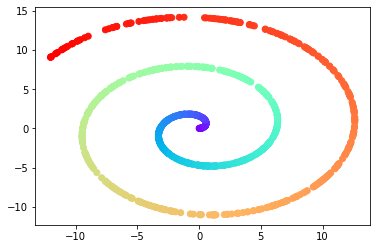

In [7]:
plt.scatter(spiral[:,0],spiral[:,1],c = thetas,cmap='rainbow')

In [89]:
diffusion_map_trunc = diffmap(spiral, 0.1, t = 100, m = 1)

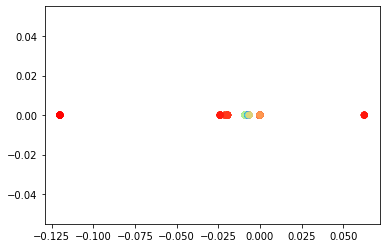

In [91]:
plt.scatter(diffusion_map_trunc[:], [0]*diffusion_map_trunc.shape[0],c=thetas,cmap ='rainbow')

In [92]:
diffusion_map_trunc = diffmap(spiral, 1, t = 100, m = 1)

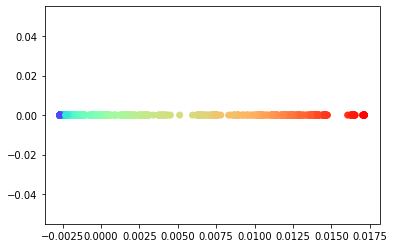

In [93]:
plt.scatter(diffusion_map_trunc[:], [0]*diffusion_map_trunc.shape[0],c=thetas,cmap ='rainbow')

**Remark & Question:**

An observation in this case is that when sigma becomes too small say 0.1, the points become too close to each other and we cannot infer useful information from the results.

In [11]:
digits_X = sio.loadmat("digits.mat")['X']
digits_y = sio.loadmat("digits.mat")['y']

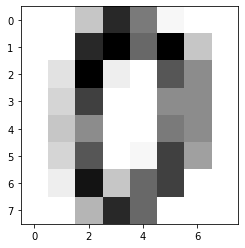

In [12]:
digits_sample = digits_X[0].reshape([8,8])
plt.imshow(digits_sample,cmap='Greys')

In [68]:
diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = 1, m = 2)

In [69]:
diffusion_map_trunc.shape

(901, 2)

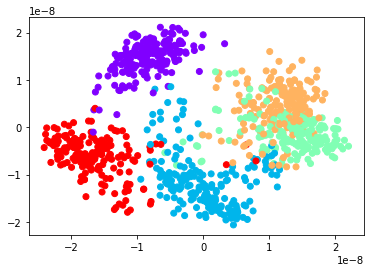

In [70]:
plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')

In [102]:
diffusion_map_trunc_prime = diffmap(digits_X, sigma =1, t = 1, m = 2)

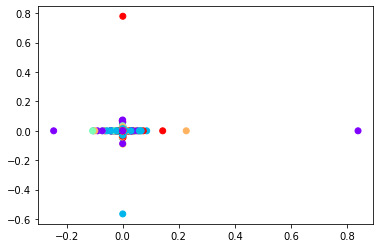

In [103]:
plt.scatter(diffusion_map_trunc_prime[:,0], diffusion_map_trunc_prime[:,1], c = digits_y, cmap ='rainbow')

**Remark & Question:**

In the homework document, it was mentioned that sigma should be as small as possible while still strongly connecting nearby points. However, in this case, only when sigma is large, say, sigma = 5000, can we see good results. Is "how small/big sigma is" something that depends on the dimensionality of the original data?  

In [16]:
digits_y[0:20]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [1],
       [2],
       [3],
       [4],
       [0],
       [0],
       [4],
       [1],
       [3]])

No handles with labels found to put in legend.


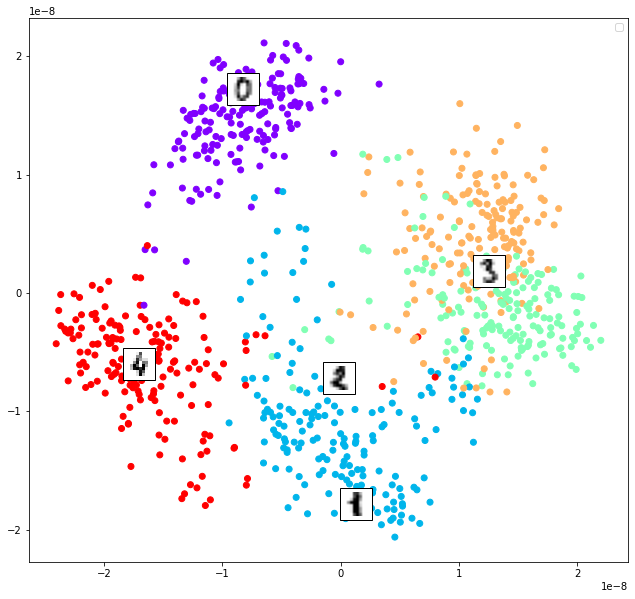

In [71]:
plt.figure(figsize=(12, 10))
    
ax = plt.subplot(aspect='equal')

plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')

for i in range(5):
    img = digits_X[i].reshape([8,8])
    img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=3) 
    ax.add_artist(AnnotationBbox(img, (diffusion_map_trunc[i,0] , diffusion_map_trunc[i,1])))

plt.legend()
plt.show()

**Remark & Question:**

The first image showing digit '2' seems to be very near the images showing digit '1'. Shifting to the next set of digits '0' to '5' seems to give a better visualization. However, this points out a potential concern in diffusion map technique: how can better we distinguish the points that are "near" in terms of diffusion distance? 

Some follow-up questions:
1. Does this matter, i.e., does this constitute some error/inaccuracies/loss of information w.r.t. the original data? 
2. And if so, is there a way to quantify the amount of error of dimensionality reduction using diffusion map technique? 
3. How can one systematically "tune" diffusion maps? Are there better non-linear dimensionality reduction techniques out there? How does diffusion map compare to, say, t-SNE?  

No handles with labels found to put in legend.


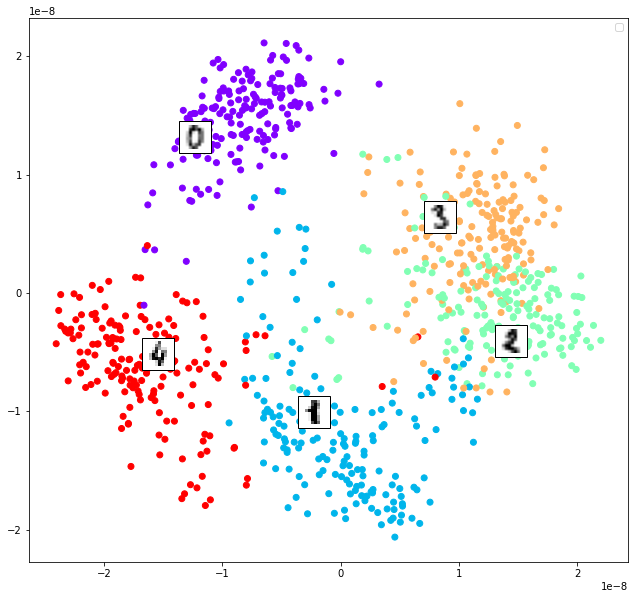

In [73]:
plt.figure(figsize=(12, 10))
    
ax = plt.subplot(aspect='equal')

plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')


for i in range(5):
    img = digits_X[i].reshape([8,8])
    img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=3) 
    ax.add_artist(AnnotationBbox(img, (diffusion_map_trunc[i+10,0] , diffusion_map_trunc[i+10,1])))

plt.legend()
plt.show()

Text(0.5, 0.98, 'Visualizing Diffusion Maps as t Advances (Digits Data)')

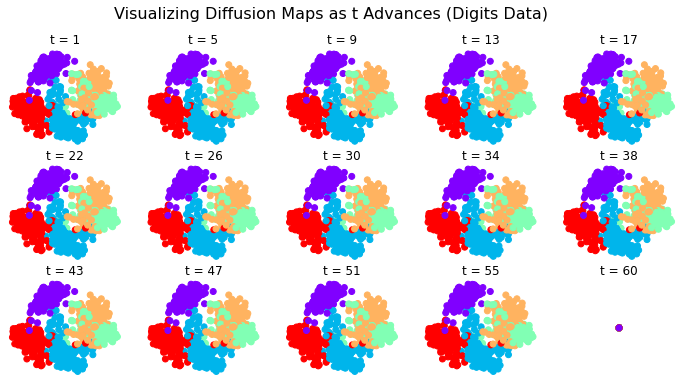

In [25]:
t_values = np.linspace(1, 60, 15, dtype=np.int32)
fig, axs = plt.subplots(3, 5, figsize = (12,6))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = t_values[i], m = 2)
    ax.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')
    ax.xaxis.set_label_position('top')
    ax.axis('off')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
fig.suptitle('Visualizing Diffusion Maps as t Advances (Digits Data)', fontsize=16)

Text(0.5, 0.98, 'Visualizing Diffusion Maps as t Advances (Digits Data t = [55,60])')

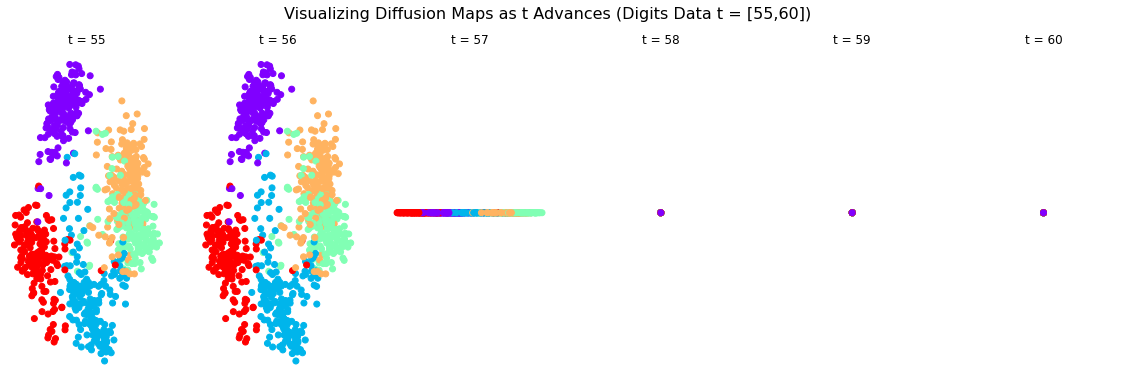

In [35]:
t_values = np.linspace(55, 60, 6, dtype=np.int32)
fig, axs = plt.subplots(1, 6, figsize = (20,6))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(digits_X, sigma =5000, t = t_values[i], m = 2)
    ax.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')
    ax.axis('off')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
fig.suptitle('Visualizing Diffusion Maps as t Advances (Digits Data t = [55,60])', fontsize=16)

Text(0.5, 0.98, 'Visualizing Diffusion Maps as t Advances (Spiral Data)')

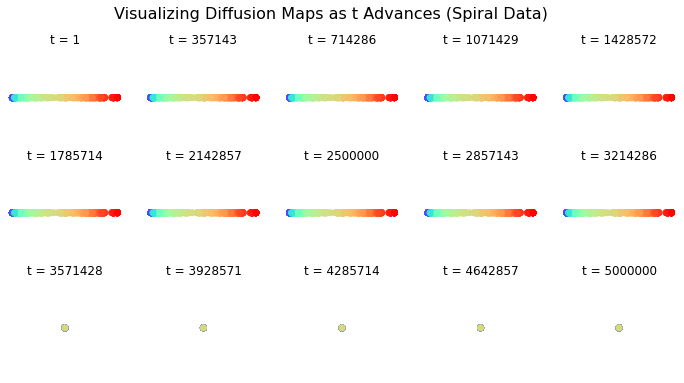

In [37]:
t_values = np.linspace(1, 5000000, 15, dtype=np.int32)
fig, axs = plt.subplots(3, 5, figsize = (12,6))
for i , ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap(spiral, sigma = 1, t = t_values[i], m = 1)
    ax.scatter(diffusion_map_trunc[:], [0]*diffusion_map_trunc.shape[0],c=thetas,cmap ='rainbow')
    ax.axis('off')
    ax.set_title('t = ' + str(t_values[i]), fontsize=12)
fig.suptitle('Visualizing Diffusion Maps as t Advances (Spiral Data)', fontsize=16)

In [38]:
print(digits_X.shape)
print(spiral.shape)

(901, 64)
(1000, 2)


**Remark & Question:**

*   For the digits data, as soon as $t$ reaches $58$, the mass distribution of a random walk starting with any point in the original data tends to the stationary distribution, making the distances in the diffusion map space zero (observed by the fact that there is only one dot in the diffusion map coordinates). 

*   For the spiral data, this stationary distribution is only reached as $t$ approaches $3500000$. 

*   Some preliminary ideas: 
    * Viewing the random walk in the continuous setting, the process can be modelled by a differential equation with t being continuous time instead of discrete steps. If we choose to model this proecess with a heat equation, then the stationary distribution is just the thermal equilibrium. However, this is just an initial guess, I will need to think more about it and read more references to be able to understand this fully. 
    * Would the dimension matter? For example, dimension of the original data, or number of diffusion map coordinates vectors taken? 


### Choosing different pairs of diffusion coordinates: 

From the plot for diffusion map on MNIST digits data, it is observed that the closest two digits are '2' and '3'. Now, we modify the code to allow for customized pair of diffusion coordinates. First, we choose the second and the third diffusion coordinates. 

In [53]:
def diffmap_alt(xs, sigma, t, i, j):
    W = np.exp(-euclidean_distances(xs, xs) ** 2 /(2 * (sigma ** 2)))
    
    ## d is a vector containing the row sums of W
    d = W.sum(axis=0)
    D_inv = np.diag(1/d)
    D_left = np.diag(d ** (-0.5))
    D_right = np.diag(d ** 0.5)
    
    M = D_inv @ W
    M_s = (D_right @ M) @ D_left
    
    ## M_s has nice real eigvecs and eigvals
    eigvals, eigvecs = eigh(M_s)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    Phi = D_left @ eigvecs
    Lambda = eigvals ** t
    
    diffusion_map = Phi @ np.diag(Lambda)
    # print(diffusion_map.shape)
    # diffusion_map[:,i].reshape([diffusion_map[:,i].shape[0], 1])
    # diffusion_map[:,j].reshape([diffusion_map[:,j].shape[0], 1])
    # print(diffusion_map[:,i].shape)
    diffusion_map_trunc = diffusion_map[:,[i,j]]
    # print(diffusion_map_trunc.shape)
#     diffusion_map_trunc = eigvecs[:,1:(m + 1)] @ np.diag(eigvals[1:(m + 1)]) 
    
    return diffusion_map_trunc

No handles with labels found to put in legend.


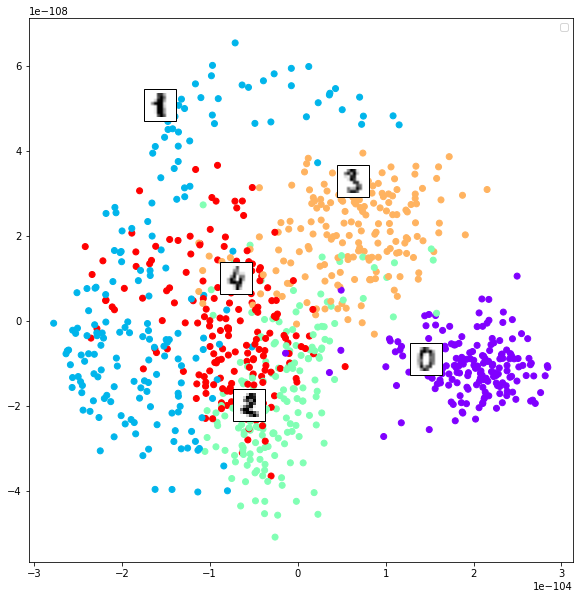

In [59]:
plt.figure(figsize=(12, 10))
    
ax = plt.subplot(aspect='equal')

diffusion_map_trunc = diffmap_alt(digits_X, sigma =5000, t = 20, i = 2, j = 3)
plt.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')


for i in range(5):
    img = digits_X[i].reshape([8,8])
    img = OffsetImage(img, cmap=plt.cm.gray_r, zoom=3) 
    ax.add_artist(AnnotationBbox(img, (diffusion_map_trunc[i+5,0] , diffusion_map_trunc[i+5,1])))

plt.legend()
plt.show()

It is clear from the above plot that the distribution of points in the diffusion space is very different now. It seems that digits '2' and '4' are now closest. 

Text(0.5, 0.98, 'Visualizing Diffusion Maps with Different Diffusion Coordinates')

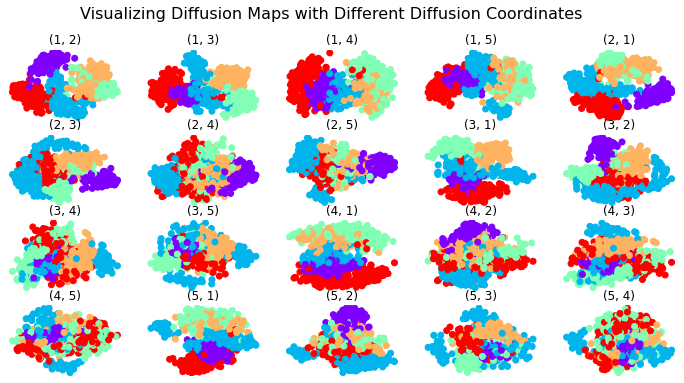

In [63]:
pair_ij = []

for i in range(1,6):
  for j in range(1,6):
    if(i != j ):
      pair_ij.append((i,j))

fig, axs = plt.subplots(4, 5, figsize = (12,6))
for k, ax in enumerate(axs.flatten()):
    diffusion_map_trunc = diffmap_alt(digits_X, sigma =5000, t = 20, i = pair_ij[k][0], j = pair_ij[k][1])
    ax.scatter(diffusion_map_trunc[:,0], diffusion_map_trunc[:,1], c = digits_y, cmap ='rainbow')
    ax.xaxis.set_label_position('top')
    ax.axis('off')
    ax.set_title('(' + str(pair_ij[k][0]) + ', ' + str(pair_ij[k][1]) + ')', fontsize=12)
fig.suptitle('Visualizing Diffusion Maps with Different Diffusion Coordinates', fontsize=16)